# Support/Resistance Pattern Detection with Replay Mode

This notebook replicates the sr_patterns.py functionality with an added **replay mode**.

Set `REPLAY_TIME` to a datetime string (e.g., `"2026-01-20 14:00"`) to see what the chart and patterns would have looked like at that historical moment. Future candles are shown in gray.

In [71]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_PATH = "riverusdt_1h.csv"
START_DATE = "2026-01-17"  # Set to None to use all data

# REPLAY MODE: Set to a datetime string to replay historical moment
# Format: "YYYY-MM-DD HH:MM" (24-hour format)
# Set to None for normal mode (use all data as current)
REPLAY_TIME = None #"2026-01-22 12:00"  # e.g., "2026-01-20 14:00"
# =============================================================================

In [72]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import datetime

from support_resistance import (
    SRParams, PatternResult,
    extract_token_and_interval, parse_replay_time, detect_patterns,
)

In [73]:
def plot_patterns(result: PatternResult, title: str = "Support & Resistance Patterns"):
    """
    Plot all detected patterns.
    
    If result.replay_idx is set, candles after that index are shown in gray:
    - Hollow (outline only) for bullish candles (close >= open)
    - Filled for bearish candles (close < open)
    """
    df = result.df
    replay_idx = result.replay_idx

    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot candlesticks
    times = df["open_time"].to_numpy()
    opens = df["open"].to_numpy()
    highs = df["high"].to_numpy()
    lows = df["low"].to_numpy()
    closes = df["close"].to_numpy()

    width = 0.02
    for i in range(len(df)):
        is_future = replay_idx is not None and i > replay_idx
        is_bullish = closes[i] >= opens[i]
        
        if is_future:
            wick_color = "#B0B0B0"
            if is_bullish:
                face_color = "none"
                edge_color = "#B0B0B0"
            else:
                face_color = "#B0B0B0"
                edge_color = "#B0B0B0"
        else:
            if is_bullish:
                wick_color = "#26a69a"
                face_color = "#26a69a"
                edge_color = "#26a69a"
            else:
                wick_color = "#ef5350"
                face_color = "#ef5350"
                edge_color = "#ef5350"
        
        ax.plot([times[i], times[i]], [lows[i], highs[i]], color=wick_color, linewidth=0.8)
        body_bottom = min(opens[i], closes[i])
        body_height = abs(closes[i] - opens[i])
        rect = Rectangle(
            (mdates.date2num(times[i]) - width / 2, body_bottom),
            width, body_height,
            facecolor=face_color, edgecolor=edge_color, linewidth=1.2
        )
        ax.add_patch(rect)

    # Plot EMA (semi-transparent blue line)
    if result.ema is not None:
        if replay_idx is not None:
            ema_times = times[:replay_idx + 1]
            ema_values = result.ema[:replay_idx + 1]
        else:
            ema_times = times
            ema_values = result.ema
        ax.plot(ema_times, ema_values, color="#2196F3", linewidth=2, alpha=0.6,
                label="EMA", zorder=4)

    # Only show local highs/lows up to replay_idx
    if replay_idx is not None:
        df_visible = df.filter(pl.col("bar_index") <= replay_idx)
    else:
        df_visible = df
    
    local_highs = df_visible.filter(pl.col("is_local_high"))
    local_lows = df_visible.filter(pl.col("is_local_low"))

    if local_highs.height > 0:
        ax.scatter(local_highs["open_time"].to_numpy(), local_highs["high"].to_numpy(),
                   marker="v", color="red", s=30, alpha=0.7, zorder=5, label=f"Local Highs ({local_highs.height})")
    if local_lows.height > 0:
        ax.scatter(local_lows["open_time"].to_numpy(), local_lows["low"].to_numpy(),
                   marker="^", color="lime", s=30, alpha=0.7, zorder=5, label=f"Local Lows ({local_lows.height})")

    # Calculate right edge for S/R zone lines (extend past last candle for labels)
    time_delta = times[-1] - times[-2] if len(times) >= 2 else np.timedelta64(1, 'h')
    x_right_edge = times[-1] + time_delta * 5
    if replay_idx is not None:
        x_right_edge = times[min(replay_idx, len(times) - 1)] + time_delta * 5

    # Plot horizontal zones as lines (light yellow) extending to right edge with price labels
    for zone in result.horizontal_zones:
        alpha = min(0.9, 0.5 + zone.strength * 0.1)
        linewidth = min(2.5, 1 + zone.touches * 0.3)

        x_start = times[zone.start_idx]

        ax.hlines(y=zone.price_center, xmin=x_start, xmax=x_right_edge,
                  color="#FFEB3B", linewidth=linewidth, alpha=alpha, linestyle="-")

        ax.text(x_right_edge, zone.price_center, f" {zone.price_center:.4f}",
                fontsize=7, color="black", va="center", ha="left",
                bbox=dict(boxstyle="round,pad=0.15", facecolor="#FFEB3B", edgecolor="none", alpha=0.9),
                clip_on=True)

    # Helper to convert bar index to time
    def idx_to_time(idx):
        if idx < len(times):
            return times[idx]
        else:
            time_delta = times[-1] - times[-2]
            return times[-1] + time_delta * (idx - len(times) + 1)

    def get_line_end_idx(line):
        if replay_idx is not None:
            return min(line.x2, replay_idx + 30)
        return line.x2

    # Plot support lines (green)
    for i, line in enumerate(result.support_lines[:10]):
        style = "-" if line.slope >= 0 else "--"
        alpha = min(0.7, 0.3 + line.strength * 0.1)
        end_idx = get_line_end_idx(line)
        end_y = line.y1 + line.slope * (end_idx - line.x1)
        ax.plot([idx_to_time(line.x1), idx_to_time(end_idx)], [line.y1, end_y],
                color="green", linewidth=1, linestyle=style, alpha=alpha)

    # Plot resistance lines (red)
    for i, line in enumerate(result.resistance_lines[:10]):
        style = "-" if line.slope <= 0 else "--"
        alpha = min(0.7, 0.3 + line.strength * 0.1)
        end_idx = get_line_end_idx(line)
        end_y = line.y1 + line.slope * (end_idx - line.x1)
        ax.plot([idx_to_time(line.x1), idx_to_time(end_idx)], [line.y1, end_y],
                color="red", linewidth=1, linestyle=style, alpha=alpha)

    # Highlight triangles
    for tri in result.triangles:
        sup, res = tri.support_line, tri.resistance_line
        
        apex_x_display = tri.apex_x
        if replay_idx is not None:
            apex_x_display = min(apex_x_display, replay_idx + 50)
        apex_y_display = sup.y1 + sup.slope * (apex_x_display - sup.x1)

        ax.plot([idx_to_time(sup.x1), idx_to_time(apex_x_display)],
                [sup.y1, apex_y_display],
                color="blue", linewidth=2, alpha=0.8)
        
        apex_y_res = res.y1 + res.slope * (apex_x_display - res.x1)
        ax.plot([idx_to_time(res.x1), idx_to_time(apex_x_display)],
                [res.y1, apex_y_res],
                color="blue", linewidth=2, alpha=0.8)

        ax.scatter([idx_to_time(tri.apex_x)], [tri.apex_price],
                   marker="*", color="yellow", s=200, zorder=10, edgecolor="black")

        bias_color = "green" if tri.breakout_bias == "bullish" else ("red" if tri.breakout_bias == "bearish" else "gray")
        ax.annotate(f"{tri.pattern_type}\n{tri.completion_pct:.0f}% complete\n{tri.breakout_bias}",
                    xy=(idx_to_time(tri.apex_x), tri.apex_price),
                    xytext=(10, 10), textcoords="offset points",
                    fontsize=9, color=bias_color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Plot consolidation zones (orange rectangles)
    for cz in result.consolidation_zones:
        if replay_idx is not None and cz.start_idx > replay_idx:
            continue
            
        x_start = times[cz.start_idx]
        end_idx = cz.end_idx
        if replay_idx is not None:
            end_idx = min(end_idx, replay_idx)
        x_end = times[min(end_idx, len(times) - 1)]

        rect = Rectangle(
            (mdates.date2num(x_start), cz.price_low),
            mdates.date2num(x_end) - mdates.date2num(x_start),
            cz.price_high - cz.price_low,
            facecolor="orange", alpha=0.25, edgecolor="orange",
            linewidth=1.5, linestyle="--", zorder=2
        )
        ax.add_patch(rect)

        if cz.duration >= 15:
            mid_idx = (cz.start_idx + min(cz.end_idx, end_idx)) // 2
            mid_time = times[mid_idx]
            ax.annotate(f"Consol\n{cz.duration} bars\n{cz.channel_width_pct*100:.1f}%",
                        xy=(mid_time, cz.price_high),
                        xytext=(0, 5), textcoords="offset points",
                        fontsize=8, color="darkorange", ha="center",
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))

    # Add replay time indicator line
    if replay_idx is not None:
        replay_time = times[replay_idx]
        replay_time_str = str(replay_time)[:16]
        ax.axvline(x=replay_time, color="red", linewidth=2, linestyle="--", alpha=0.8, zorder=15)
        ax.text(replay_time, ax.get_ylim()[1], f" REPLAY: {replay_time_str} ",
                fontsize=10, color="white", va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", edgecolor="none", alpha=0.9))

    # Trend indicator box
    if result.current_trend == 1:
        trend_color, trend_text = "green", f"UP\n{result.trend_slope:+.2f}%"
    elif result.current_trend == -1:
        trend_color, trend_text = "red", f"DOWN\n{result.trend_slope:+.2f}%"
    else:
        trend_color, trend_text = "gray", f"SIDE\n{result.trend_slope:+.2f}%"

    ax.text(0.98, 0.98, trend_text, transform=ax.transAxes,
            fontsize=12, fontweight="bold", color="white",
            verticalalignment="top", horizontalalignment="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor=trend_color, alpha=0.8))

    # Stats box
    stats_text = (f"S/R Zones: {len(result.horizontal_zones)}\n"
                  f"Support: {len(result.support_lines)}\n"
                  f"Resistance: {len(result.resistance_lines)}\n"
                  f"Triangles: {len(result.triangles)}\n"
                  f"Consolidation: {len(result.consolidation_zones)}")
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    plt.xticks(rotation=45)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

    return fig, ax

In [74]:
# Load and prepare data
token, interval = extract_token_and_interval(DATA_PATH)
print(f"Loading data from: {DATA_PATH}")

df = pl.read_csv(DATA_PATH)
df = df.with_columns([
    pl.col("open_time").str.to_datetime("%Y-%m-%d %H:%M:%S")
])

# Filter by start date if specified
if START_DATE:
    start_date = datetime.strptime(START_DATE, "%Y-%m-%d")
    df = df.filter(pl.col("open_time") >= start_date)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['open_time'].min()} to {df['open_time'].max()}")

Loading data from: riverusdt_1h.csv
Data shape: (240, 12)
Date range: 2026-01-17 09:00:00 to 2026-01-27 08:00:00


In [75]:
# Determine replay index if REPLAY_TIME is set
replay_idx = None

if REPLAY_TIME is not None:
    replay_dt = parse_replay_time(REPLAY_TIME)
    print(f"Replay mode enabled: {replay_dt}")
    
    # Find the bar index closest to (but not after) the replay time
    df_temp = df.with_row_index("_idx")
    matching = df_temp.filter(pl.col("open_time") <= replay_dt)
    
    if matching.height == 0:
        print(f"Warning: No data before {replay_dt}. Using first bar.")
        replay_idx = 0
    else:
        replay_idx = int(matching["_idx"][-1])
        replay_time_str = str(df['open_time'][replay_idx])[:16]
        print(f"Replay bar index: {replay_idx} (time: {replay_time_str})")
        print(f"Future bars shown in gray: {len(df) - replay_idx - 1}")
else:
    print("Normal mode (no replay)")

Normal mode (no replay)


In [76]:
# Detect patterns
params = SRParams(
    window_left=1,
    window_right=5,
    atr_period=14,
    atr_multiplier=0.5,
    lookback=100,
    min_touches=2,
    zone_merge_factor=1.5,
    slope_tolerance=0.0001,
    max_lines=15
)

result = detect_patterns(df, params, replay_idx=replay_idx)

print(f"\nDetected patterns (as of {'replay time' if replay_idx else 'current'}):")
print(f"  Horizontal zones: {len(result.horizontal_zones)}")
print(f"  Support lines: {len(result.support_lines)}")
print(f"  Resistance lines: {len(result.resistance_lines)}")
print(f"  Triangles: {len(result.triangles)}")
print(f"  Consolidation zones: {len(result.consolidation_zones)}")
print(f"  Current eps: {result.eps:.6f}")


Detected patterns (as of current):
  Horizontal zones: 4
  Support lines: 5
  Resistance lines: 0
  Triangles: 0
  Consolidation zones: 0
  Current eps: 2.042500


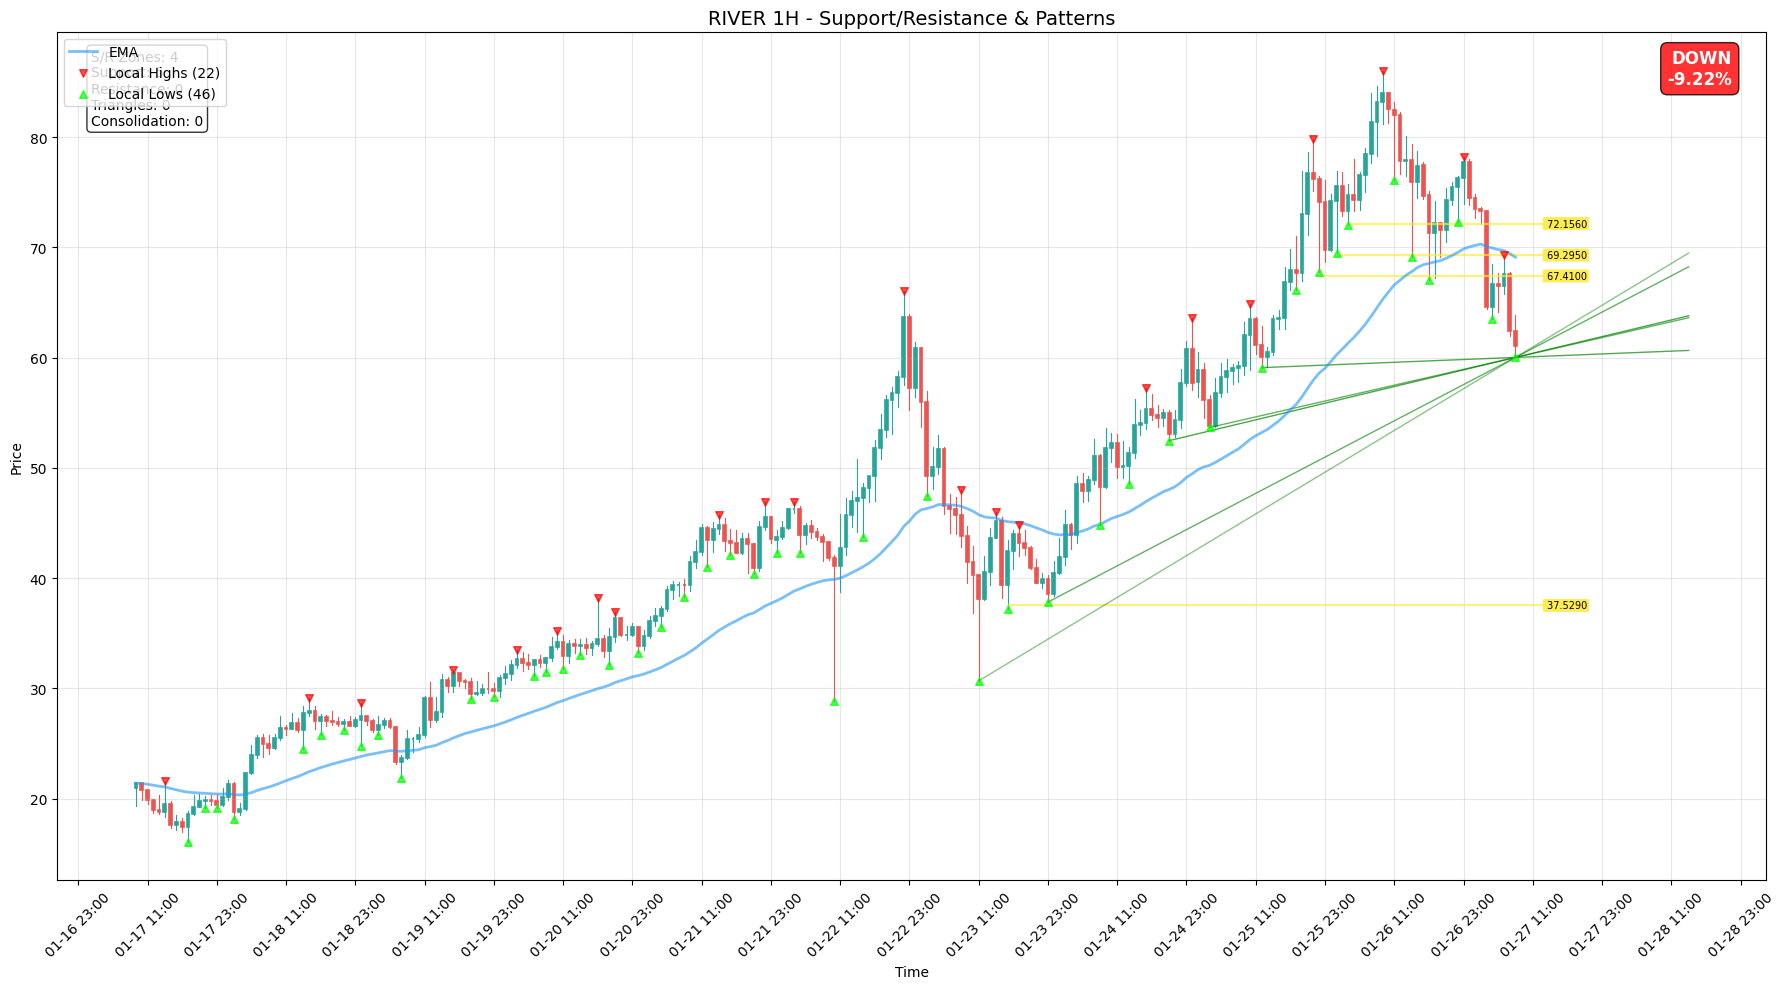

(<Figure size 1800x1000 with 1 Axes>,
 <Axes: title={'center': 'RIVER 1H - Support/Resistance & Patterns'}, xlabel='Time', ylabel='Price'>)

In [77]:
# Plot with dynamic title
if replay_idx is not None:
    replay_time_str = str(df['open_time'][replay_idx])[:16]
    title = f"{token} {interval} - S/R Patterns (Replay: {replay_time_str})"
else:
    title = f"{token} {interval} - Support/Resistance & Patterns"

plot_patterns(result, title)

In [78]:
# Print detected triangles
for tri in result.triangles:
    print(f"\n  Triangle: {tri.pattern_type}")
    print(f"    Bias: {tri.breakout_bias}")
    print(f"    Completion: {tri.completion_pct:.1f}%")
    print(f"    Apex at bar {tri.apex_x}, price {tri.apex_price:.4f}")

In [79]:
# Print consolidation zones
for cz in result.consolidation_zones:
    print(f"\n  Consolidation: bars {cz.start_idx}-{cz.end_idx} ({cz.duration} bars)")
    print(f"    Range: {cz.price_low:.4f} - {cz.price_high:.4f} ({cz.channel_width_pct*100:.2f}%)")
    print(f"    Avg slope: {cz.avg_slope:.6f}")